In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import dask.array as da

## 01 Data Exploration

### (b) Load dataset

In [2]:
df = dd.read_csv("orders.csv", dtype = {
        "id" : "int", 
        "timestamp" : "int", 
        "market" : "category",
        "pair" : "str",
        "side" : "category",
        "quantity" : "float",
        "price" : "float",
        "order_type" : "category",
        "execution_time" : "float"
    }
)

In [3]:
df.head()

,id,timestamp,market,pair,side,quantity,price,order_type,execution_time
0,1,1733000400000165,BINANCE,ETH_USDT,ASK,0.316,368.4531,Limit,7.280
1,2,1733000400000970,HUOBI,ADA_USDT,BID,0.545,188.0561,Market,1.798
2,3,1733000400001831,KRAKEN,ADA_USDT,BID,0.768,552.3179,Market,9.086
3,4,1733000400001953,KRAKEN,LTC_USDT,BID,0.214,975.9048,Limit,2.879
4,5,1733000400002031,HUOBI,LTC_USDT,ASK,0.934,734.8854,Market,0.444


### (c) Find data loss periods if any

In [4]:
timestamp_desc = df.loc[:, "timestamp"].describe().compute()
timestamp_desc

count    4.290032e+07
mean     1.803201e+11
std      2.493128e+10
min      1.733000e+15
25%      1.733022e+15
50%      1.733043e+15
75%      1.733065e+15
max      1.733087e+15
Name: timestamp, dtype: float64

In [20]:
unit_time_ms = 15 * 60 * 1000 # targetting 15 minutes per bar
bins0 = np.arange(timestamp_desc["min"], timestamp_desc["max"] + unit_time_ms, unit_time_ms)
print(len(bins0))

96001


Given that there are around 43M rows, with 96k bins, we expect around 448 samples per bar in a uniformly-distributed scenario.  
A histogram of the timestamp data shows 3 potential gaps in which there are consistently relatively low data counts.

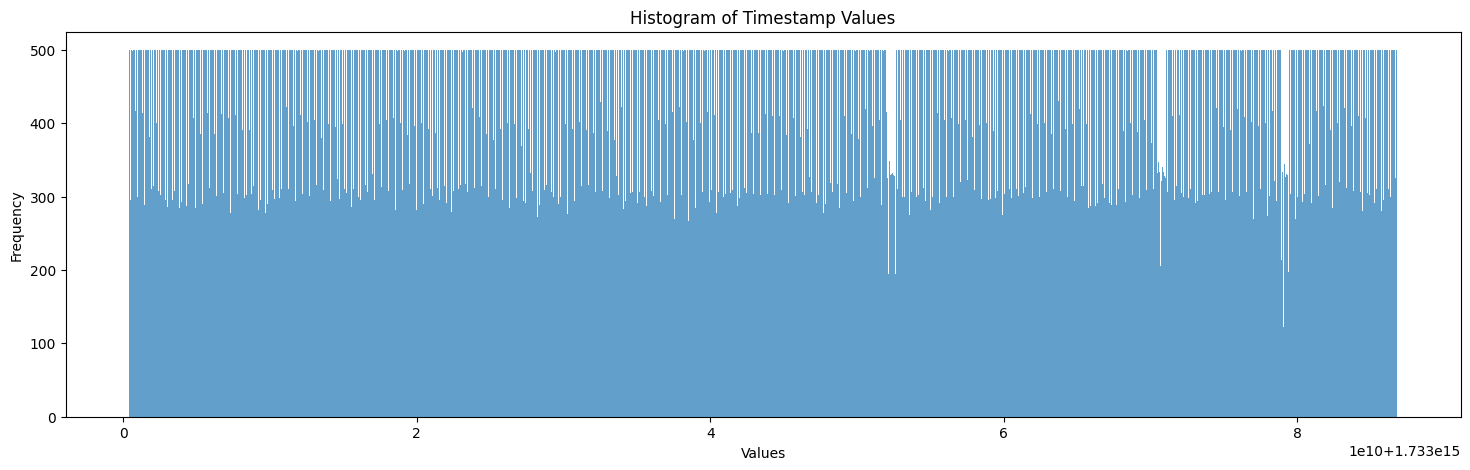

In [21]:
hist, bins = da.histogram(df.loc[:, "timestamp"].values, bins = bins0)
hist = hist.compute()

# Plot with matplotlib
plt.figure(figsize = (18, 5))
plt.hist(bins[:-1], bins = bins, weights = hist, alpha = 0.7)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Timestamp Values')
plt.show()

In [22]:
bar_sizes = bins[1:] - bins[:-1]
assert all(bar_sizes == bar_sizes[0])
print(f"Each bar represents {np.mean(bar_sizes)}ms")

Each bar represents 900000.0ms


When the count of data per bar is plotted directly in a line chart, it clearly shows the following:
1. Most bars have a data count between (roughly) 280 to 500.
2. There are 3 clusters of data with significantly lower data count.
3. We can identify approximately, the clusters with low data count by filtering for data counts below 200.

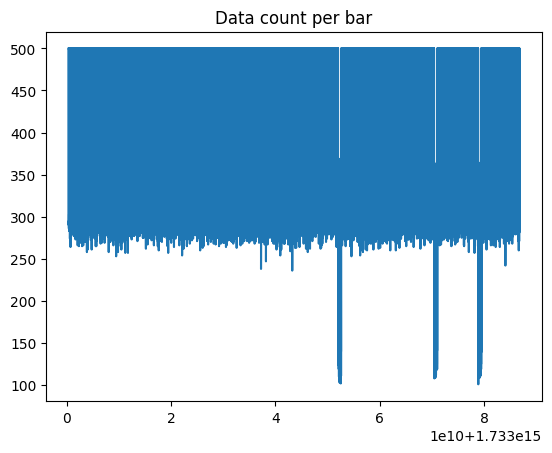

In [35]:
plt.plot(bins[:-1], hist)
_ = plt.title("Data count per bar")

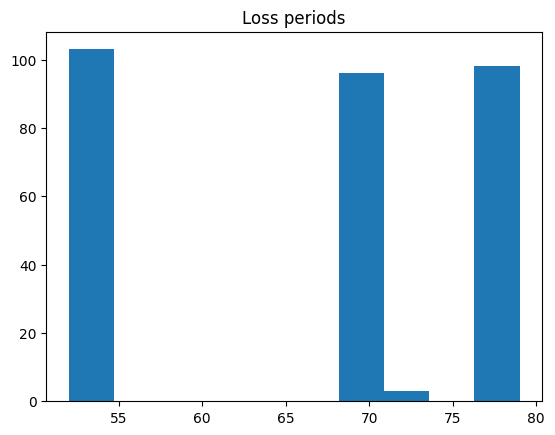

In [36]:
loss_periods = bins[:-1][hist < 200]
loss_periods_sf = (loss_periods % 1.733e15) // 1e9

_ = plt.hist(loss_periods_sf)
_ = plt.title("Loss periods")

In [32]:
loss_period_1 = loss_periods[loss_periods_sf < 60]
loss_period_2 = loss_periods[np.logical_and(loss_periods_sf >= 60, loss_periods_sf <= 75)]
loss_period_3 = loss_periods[loss_periods_sf > 75]

In [33]:
print(f"Loss period 1: {np.min(loss_period_1)} to {np.max(loss_period_1) + bar_sizes[0]}")
print(f"Loss period 2: {np.min(loss_period_2)} to {np.max(loss_period_2) + bar_sizes[0]}")
print(f"Loss period 3: {np.min(loss_period_3)} to {np.max(loss_period_3) + bar_sizes[0]}")

Loss period 1: 1733052023100165.0 to 1733052618000165.0
Loss period 2: 1733070428100165.0 to 1733071014000165.0
Loss period 3: 1733078860200165.0 to 1733079456000165.0
